##### Example of Propensity score method from: https://www.kaggle.com/code/harrywang/propensity-score-matching-in-python/notebook

Disclaimer: The participant clinical data is not fully public and is not provided in the data folder. This notebook should be regarded as an example of application of propensity matching that could be applied on other datasets.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DATA_FOLDER = '..\\data'
# Please replace the dataset with the one you would like to work with
df = pd.read_csv(os.path.join(DATA_FOLDER, 'colive_voice_clean_clinical_data_extraction_16032023.csv'), index_col="Unnamed: 0")

In [4]:
df.gender.value_counts()

female    3303
male      1516
other       31
Name: gender, dtype: int64

<AxesSubplot:xlabel='age', ylabel='gender'>

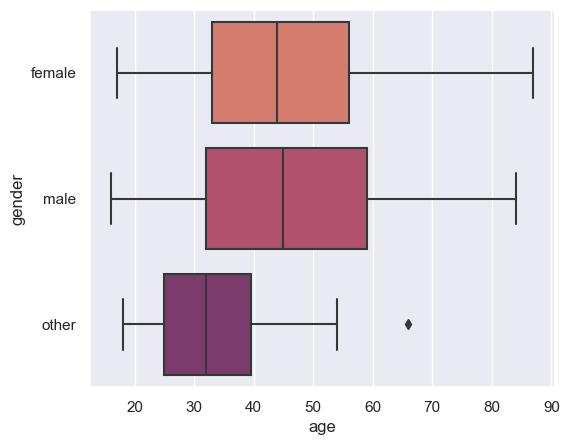

In [5]:
#set theme
sns.set_theme(style='darkgrid')
# create figure and axes
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
sns.boxplot(data=df, x="age", y="gender", palette='flare')

In [6]:
df['currently_smoking'] = df['smk_1']!='not-at-all'
df['currently_smoking'].value_counts()

False    4150
True      700
Name: currently_smoking, dtype: int64

In [7]:
df['never_smoked'] = np.logical_and(df['smk_1']=='not-at-all', df['smk_3']=='not-at-all')
df['never_smoked'].value_counts()

True     2549
False    2301
Name: never_smoked, dtype: int64

In [8]:
df['smoked_at_some_point'] = np.logical_or(df['smk_1']!='not-at-all', df['smk_3']!='not-at-all')
df['smoked_at_some_point'].value_counts()

False    2549
True     2301
Name: smoked_at_some_point, dtype: int64

In [9]:
# Survey local is the language
df['surveyLocale'].value_counts()

fr    2407
en    2296
de      55
es      36
Name: surveyLocale, dtype: int64

<AxesSubplot:xlabel='age', ylabel='gender'>

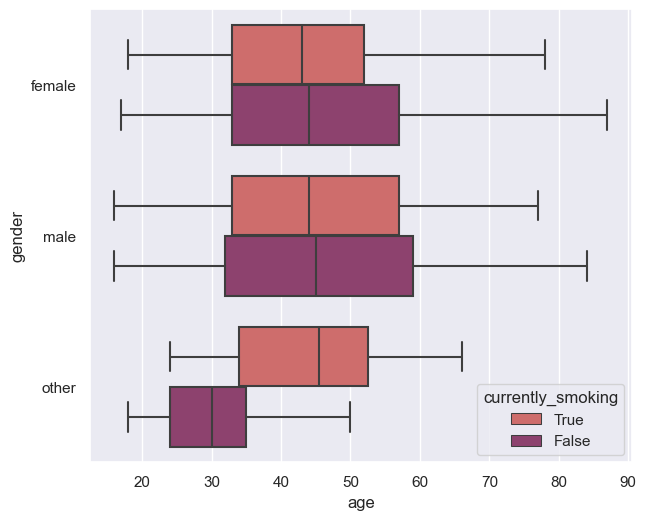

In [10]:
fig, ax = plt.subplots(figsize=(7, 6), dpi=100)
sns.boxplot(data=df, x="age", y="gender", hue="currently_smoking", hue_order=[True, False], palette='flare')

#### Making necessary columns for propensity score computation

In [14]:
# including only French and English speakers
df = df[df['surveyLocale'].isin(['fr', 'en'])]
# including only current smokers or never-smokers
df = df[(df['currently_smoking'] == True) | (df['never_smoked'] == True)]
df['currently_smoking'].replace([True, False],[1, 0], inplace=True)
# encoding languages using numbers: 1 for English and 2 for French
df['surveyLocale'].replace(['en', 'fr'], [1, 2], inplace=True)

##### Statistical functions

In [15]:
from scipy import stats

def chi2_function(df, outcome, colname=''):
    df_chi2 = pd.DataFrame([])
    columns = ['surveyLocale', 'sore-throat', 'chestpain', 'has_pulmdis', 'has_migraine', 'has_otherdis', 'has_voice_affecting_cancer', 'has_depression']
    p_values=[]
    for column in columns:
        obs = pd.crosstab(df[column], df[outcome]) 
        chi2, p, dof, ex = stats.chi2_contingency(obs, correction=True)
        p_values.append(p)
    pd.set_option('display.float_format', lambda x: '%.6f' % x)
    df_chi2[colname] = columns 
    df_chi2['chi2_pvalue'] = p_values 
    
    return df_chi2

### Propensity score matching: Male participants example

##### Data description

In [18]:
df_male = df[df['gender'] == 'male']
# Majority are French speakers
df_male['surveyLocale'].value_counts()

1    769
2    207
Name: surveyLocale, dtype: int64

In [19]:
chi2_function(df_male, 'currently_smoking')

,,chi2_pvalue
0,surveyLocale,0.016318
1,sore-throat,0.708177
2,chestpain,0.002182
3,has_pulmdis,0.022813
4,has_migraine,0.032152
5,has_otherdis,0.463813
6,has_voice_affecting_cancer,1.000000
7,has_depression,0.026043


Significant differences between current smokers and never smokers in pulmunary diseases (P < 0.001) and chest pain (P < 0.05)

In [20]:
df_male['currently_smoking'].value_counts()

0    737
1    239
Name: currently_smoking, dtype: int64

##### Propensity matching

In [29]:
X = df_male[['age', 'surveyLocale', 'sore-throat', 'chestpain', 'has_pulmdis', 'has_migraine', 'has_otherdis', 'has_voice_affecting_cancer', 'has_depression']]
y = df_male['currently_smoking']

In [31]:
df_treatment = df_male[df_male['currently_smoking']==1]
df_control = df_male[df_male['currently_smoking']==0]

<AxesSubplot:xlabel='ps', ylabel='Count'>

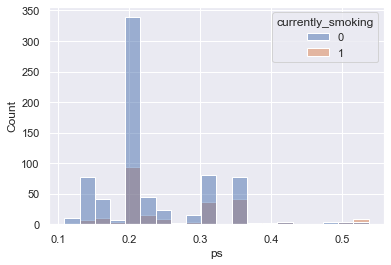

In [33]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X, y)

pred_prob = lr.predict_proba(X)  # probabilities for classes

# the propensity score (ps) is the probability of being 1 (i.e., in the treatment group)
df_male['ps'] = pred_prob[:, 1]

# check the overlap of ps for control and treatment using histogram
sns.histplot(data=df_male, x='ps', hue='currently_smoking')

In [34]:
# examples of the propensity score
df_male['ps']

22     0.227666
24     0.318535
30     0.320651
34     0.212287
45     0.290376
         ...   
4873   0.142917
4874   0.121593
4888   0.248610
4890   0.142817
4915   0.211339
Name: ps, Length: 976, dtype: float64

In [ ]:
# resetting index for the female only dataframe 
df_male.reset_index(inplace=True, drop=False)

In [36]:
from sklearn.neighbors import NearestNeighbors

# use 25% of standard deviation of the propensity score as the caliper/radius
# get the k closest neighbors for each observations
# relax caliper and increase k can provide more matches

caliper = np.std(df_male.ps) * 0.25
print(f'caliper (radius) is: {caliper:.4f}')

n_neighbors = 20

# setup knn
knn = NearestNeighbors(n_neighbors=n_neighbors, radius=caliper)

ps = df_male[['ps']]  # double brackets as a dataframe
knn.fit(ps)

caliper (radius) is: 0.0197


NearestNeighbors(n_neighbors=20, radius=0.019680119214387875)

In [37]:
# distances and indexes
distances, neighbor_indexes = knn.kneighbors(ps)

print(neighbor_indexes.shape)

# the 10 closest points to the first point
print(distances[0])
print(neighbor_indexes[0])

(976, 20)
[0.         0.         0.00021389 0.00028496 0.00064081 0.00078304
 0.00106731 0.00113834 0.00120935 0.00156418 0.00175898 0.00262629
 0.00305015 0.00305015 0.00312074 0.00319131 0.00326186 0.00354393
 0.00368487 0.00374825]
[946   0 905 871 898 887 961 967 873 917 928 939 865 438 862  90  11 945
 317 231]


In [38]:
# for each point in treatment, we find a matching point in control without replacement
# note the 10 neighbors may include both points in treatment and control

matched_control = []  # keep track of the matched observations in control

for current_index, row in df_male.iterrows():  # iterate over the dataframe
    if row.currently_smoking == 0:  # the current row is in the control group
        df_male.loc[current_index, 'matched'] = np.nan  # set matched to nan
    else: 
        for idx in neighbor_indexes[current_index, :]: # for each row in treatment, find the k neighbors
            # make sure the current row is not the idx - don't match to itself
            # and the neighbor is in the control 
            if (current_index != idx) and (df_male.loc[idx].currently_smoking == 0):
                if idx not in matched_control:  # this control has not been matched yet
                    df_male.loc[current_index, 'matched'] = idx  # record the matching
                    matched_control.append(idx)  # add the matched to the list
                    break

In [39]:
# try to increase the number of neighbors and/or caliper to get more matches
print('total observations in treatment:', len(df_male[df_male.currently_smoking==1]))
print('total matched observations in control:', len(matched_control))


total observations in treatment: 239
total matched observations in control: 237


In [42]:
# control have no match
treatment_matched = df_male.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched = df_male.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df_matched = pd.concat([treatment_matched, control_matched])

df_matched.currently_smoking.value_counts()

1    237
0    237
Name: currently_smoking, dtype: int64

In [45]:
# Assessing significant differences after matching after matching
chi2_function(df_matched, 'currently_smoking')

,,chi2_pvalue
0,surveyLocale,0.602401
1,sore-throat,0.732024
2,chestpain,0.669451
3,has_pulmdis,0.745654
4,has_migraine,0.876693
5,has_otherdis,1.000000
6,has_voice_affecting_cancer,1.000000
7,has_depression,0.766880


-> no significant differences after matching